# Trees

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score, train_test_split
import xgboost as xgb
import pickle
import math

plt.style.use('ggplot')

In [2]:
def rmsle(model, X, y):
    '''
    Calculates rmsle as set by Kaggle
    '''
    
    # Here we assume that our model predicts log prices
    
    return (math.sqrt(np.mean((model.predict(X) - y) ** 2)))

Here we use decision trees to build models of the sales price

In [3]:
# Load the train set
df = pd.read_csv('./data/new_train_school.csv')
df.drop(['Unnamed: 0', 'Id'], axis=1, inplace=True)

# Load categorical variables
numerical = pickle.load(open('./tmp/numerical.list', 'rb'))

df.shape #prev (1460, 279), +8 schools for 287

(1460, 287)

## Random Forest Regressor

In [4]:
data = df.copy()

# Create sets
X = data.copy().drop('SalePrice', axis=1)
y = np.log(data.copy()['SalePrice'])


We perform cross-validation to find optimal pruning parameters.

In [9]:
# Create placeholders for the results
min_split = []
scores = []
min_leaf = []

# Set optimization parameters
m_smpl = np.linspace(start=10, stop=100,num=91, dtype='int')
m_lf = np.linspace(2, 7, num=6, dtype='int')

# Run optimization
for smpl in m_smpl:
    for lf in m_lf:
        tree = RandomForestRegressor(min_samples_split=smpl, min_samples_leaf=lf, random_state=0)
        cv = cross_val_score(tree,X, y, cv = 10)
        score = np.mean(cv)
        min_split = min_split + [smpl]
        min_leaf = min_leaf + [lf]
        scores = scores + [score]


In [7]:
tmp_ = pd.DataFrame({'score':scores, 'smpl':min_split, 'leaf':min_leaf})

In [8]:
tmp_ = tmp_.sort_values('score', ascending=False).head(20)
tmp_

,score,smpl,leaf
0,0.866604,10,2
6,0.865971,11,2
12,0.865464,12,2
18,0.865331,13,2
24,0.864294,14,2
7,0.864089,11,3
19,0.863761,13,3
13,0.863262,12,3
1,0.863260,10,3
30,0.863103,15,2


We use optimized parameters (min_amples_split=10 and min_samples_leaf=2) to build the final model.

In [10]:
# Divide the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

#prev:
#X_train : (1022, 278)
#X_test : (438, 278)
#y_train : (1022,)
#y_test : (438,)

X_train : (1022, 286)
X_test : (438, 286)
y_train : (1022,)
y_test : (438,)


We perform train test validation

In [11]:
smpl = tmp_.iloc[0,1]
lf = tmp_.iloc[0,2]
regression_tree  = RandomForestRegressor(min_samples_split=smpl, min_samples_leaf=lf,
  random_state=0)

C:\Users\asus\Anaconda2\envs\ipykernel_py3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model train accuracy (rmsle):  0.08664127387474062
Model test accuracy (rmsle):  0.1405740941600297


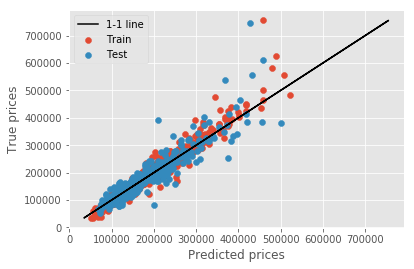

In [12]:
model_tmp = regression_tree.fit(X_train,y_train)

print('Model train accuracy (rmsle): ', rmsle(model_tmp, X_train, y_train))
print('Model test accuracy (rmsle): ', rmsle(model_tmp, X_test, y_test))

score_tree = rmsle(model_tmp, X_test, y_test) # record test score

plt.scatter(np.exp(model_tmp.predict(X_train)), np.exp(y_train), label='Train')
plt.scatter(np.exp(model_tmp.predict(X_test)), np.exp(y_test), label='Test')
plt.plot(np.exp(y), np.exp(y), c='black', label = '1-1 line')
plt.xlabel('Predicted prices')
plt.ylabel('True prices')
_ = plt.legend()

plt.savefig('./output/tree_true_vs_pred.png', dpi=300)
#prev:
#Model train accuracy (rmsle):  0.08754356723003155
#Model test accuracy (rmsle):  0.13912328237940788

Fit to the whole dataset

In [13]:
tree = RandomForestRegressor(min_samples_leaf=1,
  random_state=0)

tree = tree.fit(X,y)

print('Model accuracy rmse: ', rmsle(tree,X,y))
#prev Model accuracy rmse:  0.06328099338293965

C:\Users\asus\Anaconda2\envs\ipykernel_py3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model accuracy rmse:  0.06305069776141523


In [14]:
importance = pd.DataFrame({'features':X.columns, 'imp':regression_tree.feature_importances_}).\
                        sort_values('imp',ascending=False)

importance_top20 = importance.iloc[:20,]

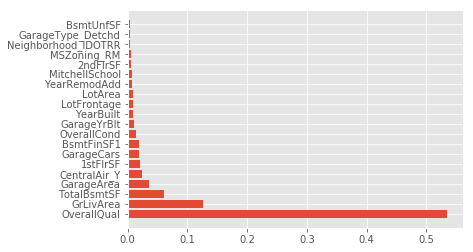

In [15]:
plt.barh(importance_top20.features, importance_top20.imp)
plt.savefig('./output/tree_factors.png', dpi=300)

List factors with positive importance

In [16]:
feature_list_dt = list(importance.loc[importance.imp>0,'features'])
feature_list_dt

['OverallQual',
 'GrLivArea',
 'TotalBsmtSF',
 'GarageArea',
 'CentralAir_Y',
 '1stFlrSF',
 'GarageCars',
 'BsmtFinSF1',
 'OverallCond',
 'GarageYrBlt',
 'YearBuilt',
 'LotFrontage',
 'LotArea',
 'YearRemodAdd',
 'MitchellSchool',
 '2ndFlrSF',
 'MSZoning_RM',
 'Neighborhood_IDOTRR',
 'GarageType_Detchd',
 'BsmtUnfSF',
 'SawyerSchool',
 'FireplaceQu_No',
 'MasVnrArea',
 'MSSubClass_60',
 'EdwardsSchool',
 'WoodDeckSF',
 'GarageQual_TA',
 'FullBath',
 'Fannie',
 'TotRmsAbvGrd',
 'MeekerSchool',
 'DJREI',
 'Fence_GdWo',
 'MiddleSchool',
 'Corn',
 'EnclosedPorch',
 'GarageType_Attchd',
 'LaborForce',
 'MoSold',
 'LotShape_Reg',
 'GarageFinish_Unf',
 'HouseStyle_2Story',
 'BsmtFinType1_Rec',
 'OpenPorchSF',
 'KitchenAbvGr',
 'UnemplRate',
 'BsmtQual_Gd',
 'Month',
 'BedroomAbvGr',
 'ExterQual_TA',
 'KitchenQual_TA',
 'KitchenQual_Gd',
 'HeatingQC_TA',
 'MasVnrType_None',
 'MSSubClass_50',
 'NorthwoodSchool',
 'MSZoning_RL',
 'SaleCondition_Normal',
 'BsmtFinType2_No',
 'RoofStyle_Hip',
 'Ha

In [25]:
len(feature_list_dt)

135

In [17]:
# Save features
pickle.dump(obj=feature_list_dt, file=open('./tmp/feaure_list_dt.list','wb'))

## Gradient Boosting

We are using boosted tree to model the prices.

In [18]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

alphas = np.linspace(1, 20, 3)

params = {"max_depth":3, "eta":0.1, "subsample":0.7}
cv_xgb = xgb.cv(params, dtrain,  num_boost_round=1000, early_stopping_rounds=100, verbose_eval=False)


[23:10:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:10:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:10:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:10:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:10:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:10:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:10:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:10:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:10:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[

[23:10:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:10:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:10:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[23:10:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[23:10:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[23:10:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[23:10:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:10:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[23:10:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[23:10:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:10:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:10:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:10:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[23:10:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[23:10:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:10:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[23:10:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[23:10:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_d

[23:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[23:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[23:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[23:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_d

[23:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[23:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[23:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[23:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[23:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[23:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[23:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[23:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_d

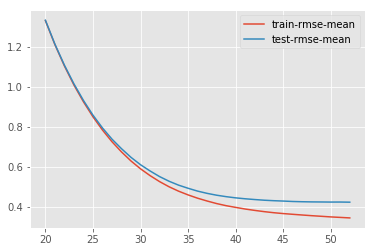

In [19]:
# Plot cv results
cv_xgb.iloc[20:, [0,2]].plot()

Fit to new test and train sets

Model train accuracy (rmsle):  0.1114276039876249
Model test accuracy (rmsle):  0.15221176191322225


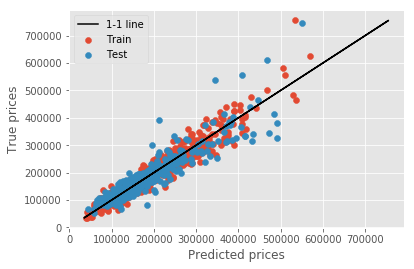

In [92]:
# Fit a model 
model_tmp = xgb.XGBRegressor(n_estimators=30, max_depth=2, learning_rate=0.6, subsample=0.7) #the params were tuned using xgb.cv
model_tmp = model_tmp.fit(X_train, y_train)

print('Model train accuracy (rmsle): ', rmsle(model_tmp, X_train, y_train))
print('Model test accuracy (rmsle): ', rmsle(model_tmp, X_test, y_test))

score_xgb = rmsle(model_tmp, X_test, y_test) #record score

plt.scatter(np.exp(model_tmp.predict(X_train)), np.exp(y_train), label='Train')
plt.scatter(np.exp(model_tmp.predict(X_test)), np.exp(y_test), label='Test')
plt.plot(np.exp(y), np.exp(y), c='black', label = '1-1 line')
plt.xlabel('Predicted prices')
plt.ylabel('True prices')
_ = plt.legend()

plt.savefig('./output/xgb_true_vs_pred.png', dpi=300)

#prev
#Model train accuracy (rmsle):  0.11607573987561702
#Model test accuracy (rmsle):  0.16570379877653624

#Model train accuracy (rmsle):  0.1114276039876249 #30
#Model test accuracy (rmsle):  0.15221176191322225


Fit to the whole dataset

In [93]:
xgb_mod = xgb.XGBRegressor(n_estimators=30, max_depth=2, learning_rate=0.6, subsample=0.7) #the params were tuned using xgb.cv
xgb_mod = xgb_mod.fit(X, y)



print('Model accuracy rmse: ', rmsle(xgb_mod, X, y))

#prev Model accuracy rmse:  0.11811972843556778

#Model accuracy rmse:  0.12415147224032057 #n_estimators=25


Model accuracy rmse:  0.11851273482889757


## Combine the models

We combine the models and pickle them for use on the train set

In [94]:
# Models

models = ['tree', 'xgb_mod']
scores = [score_tree, score_xgb]

models_comb = pd.DataFrame({'model':models, 'score': scores})
print(models_comb)

# Pickle
pickle.dump(models_comb, open('./tmp/tree_comb', 'wb'))

#prev
#     model     score
#0     tree  0.139123
#1  xgb_mod  0.165704

     model     score
0     tree  0.140574
1  xgb_mod  0.152212


Pickle models

In [95]:
models_obj = [tree, xgb_mod]

for i, model in enumerate(models_obj):
    name = './tmp/'+models[i]+'.model'
    pickle.dump(model, open(name, 'wb'))
